
![image.png](attachment:image.png)
# **APPLY MACHINE LEARNING IN PREDICTING TRAVEL INSURANCE CLAIM**
* Phuong Chi Dao - 474064
* I Putu Agastya Harta Pratama - 472876

May 2025


### Library and data import

In [ ]:
!pip install pandas numpy scikit-learn seaborn statsmodels matplotlib xgboost lightgbm mlxtend imblearn joblib

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import joblib
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import mannwhitneyu, pointbiserialr, chi2_contingency, spearmanr

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, cross_val_score, cross_val_predict, GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2 as chi2_stat
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import (balanced_accuracy_score, make_scorer, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix)
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

from copyreg import pickle
from patsy.state import standardize

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier

In [ ]:
train = pd.read_csv('insurance_train.csv')

In [ ]:
test = pd.read_csv('insurance_test.csv')

# I. Data Preprocessing

In [ ]:
train.describe()

,reward,claim_status,support_interactions,customer_score,person_age,revenue,trip_length
count,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000
mean,9.794976,0.014633,1.093941,0.189540,39.697261,40.750070,49.234888
std,19.791119,0.120081,0.923113,0.080641,12.603433,48.749221,98.659469
min,0.000000,0.000000,0.000000,0.000000,18.000000,-406.642669,1.000000
25%,0.000000,0.000000,0.000000,0.136389,34.000000,18.246389,9.000000
50%,0.000000,0.000000,1.000000,0.181041,36.000000,26.785242,22.000000
75%,11.336612,0.000000,2.000000,0.230836,44.000000,47.809948,53.000000
max,282.073580,1.000000,6.000000,1.000000,100.000000,801.049866,4856.000000


In [ ]:
train['agent_id'] = train['agent_id'].str[-2:].astype(int)
test['agent_id'] = test['agent_id'].str[-2:].astype(int)

In [ ]:
claim_counts = train['claim_status'].value_counts().sort_index()
claim_pct = (claim_counts / len(train) * 100)
claim_df = (pd.DataFrame({'count': claim_counts, 'percentage_%': claim_pct}).rename_axis("claim_status"))
display(claim_df)

,count,percentage_%
claim_status,,
0,56159,98.536662
1,834,1.463338


In general, almost insurance claims got rejected, so there is extreme class imbalance with fewer than 2% of them got accepted. Therefore, a naive model that always predicts "0" would already score 98.5% accuracy while doing nothing useful. Hence, for this dataset, the accuracy is a misleading metric, we will focus on the recall/precision, ROC-AUC instead.

For most of the variables, it stays within range. Reward, revenue are slightly skewed with right tail. The trip length is noticeable right-skew, the 75% percentile is 53 days, but the maximum length is over 13 years, it is worth to inspect these values.


We found these following information from studying the individual features:
- **Age**: The median age in both group are identical, approvals mildly concentrated in working-age (26-45); older groups approve less but cohort is small.
- **Customer score & Reward**: Customer score does have a positive correlation with the claim approval, however, having higher reward does not guarantee approval
- **Discount Flag**: negative revenue (i.e., heavily discounted sales) rarely see claim approvals.
- **Location**: The majority of approval case are based in Singapore, this could indicate that the insurance company is located in Singapore, or the majority of their client are from Singapore. Followed by United States, Canada and United Kingdom. Those are expensive destination which might require more expensive insurance package that has better protection -> higher positive claim approval
- **Agent**: For certain agents, there is higher chance of claim getting approve compare to other, especially for agent 5.
- **Identity**: Agency B has much higher approval rate, reflects the policy differences between these two.
- **Gender**: The gender in this dataset might be masked from the real value of Male, Female, Unknown, but they are valuable features and can be encoded to use as part of the classification.
- **Product**: Annual insurance product received the highest claim approval, including TravelShield Annual Pro, SecurePlan Annual Lite, Tripguard Annual Pro
- **Revenue**: The probability of a claim with higher revenue get accepted is much  higher than those that generates lower revenue.


***2.3% of all insurances*** (1 309/56 993) last **longer than one year**, and they are overwhelmingly sold ***in Singapore*** (1 115 cases, ∼85 % of annuals), followed by the U.S. (136), China (40) and other markets.  Out of all agents, ***agent 5*** (1 061 annuals), **agent 13** (182), **agent 14** (54) are handling nearly all these long-haul plans.  Underwriting varies by channel: type_b approves these annual contracts at roughly 10.6 % versus 5.9 % for type_a.  

Product-level risk is also interesting: ***TravelShield Annual Pro*** tops at 11.7 % approval, then ***SecurePlan Annual Lite*** (10.7 %), ***TripGuard Annual Pro*** (10.5 %), and SecurePlan Family (9.1 %), while other “Annual” offerings cluster below 7 %.  Together, this tells us that annual-plan policies form a distinct, high-approval cohort—sold predominantly by a few agents in Singapore under type_b entities and specific “Annual” products.

Out of 146 unique destinations, nearly one in five records come from a single destination—so “Singapore” is by far the most common location. The remainder of the world is split across hundreds of other destinations, each with far fewer observations.

In [ ]:
locs = sorted(train['location'].unique())
print("Unique locations:\n", locs)

Unique locations:
 ['albania', 'angola', 'argentina', 'armenia', 'australia', 'austria', 'azerbaijan', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'brazil', 'brunei darussalam', 'bulgaria', 'cambodia', 'cameroon', 'canada', 'cayman islands', 'chile', 'china', 'colombia', 'costa rica', 'croatia', 'cyprus', 'czech republic', 'denmark', 'dominican republic', 'ecuador', 'egypt', 'estonia', 'ethiopia', 'faroe islands', 'fiji', 'finland', 'france', 'french polynesia', 'georgia', 'germany', 'ghana', 'greece', 'guadeloupe', 'guam', 'guatemala', 'guinea', 'guinea-bissau', 'hong kong', 'hungary', 'iceland', 'india', 'indonesia', 'iran, islamic republic of', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan', 'kenya', "korea, democratic people's republic of", 'korea, republic of', 'kuwait', 'kyrgyzstan', "lao people's democratic republic", 'latvia', 'lebanon', 'lithuania', 'luxembourg', 'mac

In [ ]:
Europe = {'albania','armenia','austria','azerbaijan','belarus','belgium',
    'bosnia and herzegovina','bulgaria','croatia','cyprus',
    'czech republic','denmark','estonia','finland','france',
    'georgia','germany','greece','hungary','iceland',
    'ireland','italy','latvia','lithuania','luxembourg',
    'macedonia, the former yugoslav republic of','malta',
    'moldova, republic of','montenegro','netherlands','norway',
    'poland','portugal','romania','russian federation','serbia',
    'slovenia','spain','sweden','switzerland','ukraine','united kingdom',
    'faroe islands', 'republic of montenegro', 'reunion', 'turkey'
}

Asia = {'azerbaijan','bahrain','bangladesh','bhutan','brunei darussalam',
    'cambodia','china','georgia','hong kong','india','indonesia',
    'iran, islamic republic of','israel','japan','jordan','kazakhstan',
    "korea, democratic people's republic of",'korea, republic of',
    'kuwait','kyrgyzstan',"lao people's democratic republic",
    'lebanon','macao','malaysia','maldives','mongolia',
    'myanmar','nepal','philippines','qatar','singapore',
    'sri lanka','taiwan, province of china','tajikistan',
    'thailand','turkmenistan','viet nam','united arab emirates',
    'oman', 'pakistan', 'saudi arabia', 'tibet', 'uzbekistan'}

Africa = {'angola','botswana','cameroon','egypt','ethiopia','ghana','guinea',
    'guinea-bissau','kenya','mali','mauritius','morocco','namibia',
    'nigeria','rwanda','senegal','seychelles','sierra leone',
    'south africa','tanzania, united republic of','uganda','zambia','zimbabwe', 'tunisia'}

Americas = {'argentina','barbados','bermuda','bolivia','brazil','canada',
    'cayman islands','chile','colombia','costa rica','dominican republic',
    'ecuador','guadeloupe','guatemala','jamaica','mexico','panama',
    'peru','puerto rico','united states','uruguay','venezuela',
    'virgin islands, u.s.', 'trinidad and tobago'}

Oceania = {'australia','fiji','french polynesia','guam','new caledonia',
    'new zealand','papua new guinea','samoa','solomon islands','vanuatu', 'northern mariana islands', 'turks and caicos islands'}

# map continent variable on train
continent_map = {}
for loc in locs:
    key = loc.lower()
    if key in Europe:
        continent_map[loc] = 'Europe'
    elif key in Asia:
        continent_map[loc] = 'Asia'
    elif key in Africa:
        continent_map[loc] = 'Africa'
    elif key in Americas:
        continent_map[loc] = 'Americas'
    elif key in Oceania:
        continent_map[loc] = 'Oceania'

train['continent'] = train['location'].map(continent_map)
print(train['continent'].value_counts())

continent
Asia        45197
Europe       4658
Oceania      3847
Americas     3012
Africa        279
Name: count, dtype: int64


In [ ]:
# map continent on test set also
if "location" in test.columns:
    test["continent"] = test["location"].map(continent_map)
    print(test["continent"].value_counts())
else:
    print("Error: 'location' column not found in test_final.")

continent
Asia        5010
Europe       558
Oceania      430
Americas     311
Africa        20
Name: count, dtype: int64


Certain products carry inherently high/low claim odds

- SecurePlan Annual Lite has 10–16 % approval regardless of support interactions.
- TripGuard Cancel is essentially never approved (~0 %) and always yields zero commission. This might be due to realistic fact that people who want to cancel their insurance plans are those that contact customer support the most, however, since their insurance product got cancelled later on, their claims would never get approved because it is already cancelled.

# II. Feature Engineering

During this part, we will define new features from the finding above that allow higher confidence of prediction than the existing features.

In [ ]:
#frequency encode for location since there are just to many of them
freq = train['location'].value_counts() / len(train)
train['location_freq'] = train['location'].map(freq)

# same apply on test
freq = test['location'].value_counts() / len(test)
test['location_freq'] = test['location'].map(freq)

In [ ]:
keep_cols = ['reward', 'claim_status', 'person_gender', 'entity_type', 'channel',
    'support_interactions', 'agent_id', 'customer_score', 'entity_a',
    'person_age', 'revenue', 'product_id', 'trip_length',
    'continent', 'location', 'location_freq']

train = train[keep_cols]

In [ ]:
train_no_target = train.drop(columns=['claim_status'])
all_data = pd.concat([train_no_target, test], ignore_index=True)
claim_status = train["claim_status"]

In order to keep everything in hand, we will combine all the new features in one single place.

In [ ]:
all_data["reward_margin"]= np.where(all_data["revenue"] != 0, all_data["reward"] / all_data["revenue"],0.0)
all_data["is_discounted"]= (all_data["revenue"] < 0).astype(int)
all_data["high_reward"] = (all_data["reward"] >= all_data["reward"].quantile(0.90)).astype(int)
all_data["long_trip"] = (all_data["trip_length"] > 365).astype(int)
all_data["age_x_score"] = all_data['person_age'] * all_data['customer_score']
all_data["is_SG"] = (all_data['location'] == "singapore").astype(int)
all_data["annual_plan"] = (all_data['product_id'].str.contains('Annual|SecurePlan Family', case=False, na=False)).astype(int)
all_data["agent_annual"] = all_data["agent_id"].isin([5, 13, 14, 8, 1]).astype(int)

all_data = all_data.drop(columns=['location'])
test_final = all_data.iloc[len(train):]
train_final = all_data.iloc[:len(train)]
train_final['claim_status'] = claim_status

approved = train_final[train_final['claim_status']==1]
not_approved = train_final[train_final['claim_status']==0]

In [ ]:
test_final.columns

Index(['reward', 'person_gender', 'entity_type', 'channel',
       'support_interactions', 'agent_id', 'customer_score', 'entity_a',
       'person_age', 'revenue', 'product_id', 'trip_length', 'continent',
       'location_freq', 'reward_margin', 'is_discounted', 'high_reward',
       'long_trip', 'age_x_score', 'is_SG', 'annual_plan', 'agent_annual'],
      dtype='object')

In [ ]:
train_final.columns

Index(['reward', 'person_gender', 'entity_type', 'channel',
       'support_interactions', 'agent_id', 'customer_score', 'entity_a',
       'person_age', 'revenue', 'product_id', 'trip_length', 'continent',
       'location_freq', 'reward_margin', 'is_discounted', 'high_reward',
       'long_trip', 'age_x_score', 'is_SG', 'annual_plan', 'agent_annual',
       'claim_status'],
      dtype='object')

In [ ]:
print(sorted(train['product_id'].unique()))
print(sorted(test['product_id'].unique()))

['CruiseSafe Family', 'CruiseSafe Trip', 'DriveSafe Rental Addon', 'QuickProtect 24', 'SecurePlan Annual Lite', 'SecurePlan Family', 'SecurePlan Flex', 'SecurePlan Individual', 'SecurePlan Junior', 'SecurePlan OneWay', 'SecurePlan Standard', 'TravelShield Annual Pro', 'TravelShield Basic', 'TravelShield Core', 'TravelShield Elite', 'TravelShield Plus', 'TravelShield Premium', 'TravelShield Value', 'TripGuard Annual Lite', 'TripGuard Annual Max', 'TripGuard Annual Pro', 'TripGuard Cancel', 'TripGuard Max', 'TripGuard Plus', 'TripGuard Pro', 'TripGuard TicketCover']
['CruiseSafe Trip', 'DriveSafe Rental Addon', 'QuickProtect 24', 'SecurePlan Annual Lite', 'SecurePlan Family', 'SecurePlan Flex', 'SecurePlan Individual', 'SecurePlan Junior', 'SecurePlan OneWay', 'SecurePlan Standard', 'TravelShield Annual Pro', 'TravelShield Basic', 'TravelShield Core', 'TravelShield Elite', 'TravelShield Plus', 'TravelShield Premium', 'TravelShield Value', 'TripGuard Annual Lite', 'TripGuard Annual Max', 

We notice that in the training set there are two “CruiseSafe” products (“CruiseSafe Family” and “CruiseSafe Trip”), whereas in the final test set only “CruiseSafe Trip” appears

# III. Model Preparation

Final check up all the variables, take an overview on the correlation matrix between all features, including both old and new one

**train**: original dataset <br>
**train_final**: new train dataset with new derived features <br>
**test_enc**: final data set use for insurance claims prediction


## 1. Features selection

**Features summarization:**
- Revenue, reward and trip length are the main factors that drive claim status

- Additional important factors come from:
    - Location: Singapore, US vs other countries
    - Product type: Annual plan vs short term plan
    - Agent in charge
    - Entity type


From the above part, we have computed several extra features which behave similarly with other existing features. For instance, *annual plan* was designed to trip length that is longer than 1 year, so it highly related to *trip length*. There are also other features that correlate with each other and can be seen on the correlation heat map above.

For now, we have total 22 columns represent for 22 features, including 6 categorical and 16 numerical features. We will try different method to weight feature importance, using Wrapper method and statistical analysis.

In [ ]:
train_final.columns

Index(['reward', 'person_gender', 'entity_type', 'channel',
       'support_interactions', 'agent_id', 'customer_score', 'entity_a',
       'person_age', 'revenue', 'product_id', 'trip_length', 'continent',
       'location_freq', 'reward_margin', 'is_discounted', 'high_reward',
       'long_trip', 'age_x_score', 'is_SG', 'annual_plan', 'agent_annual',
       'claim_status'],
      dtype='object')

After considering both methods and our knowledge of data, we decide to keep all of those features from the statistical test, with extra features regarding gender and the continent.

In [ ]:
keep_cols = ['annual_plan', 'revenue', 'is_SG', 'agent_annual', 'reward',
    'trip_length', 'reward_margin', 'agent_id', 'age_x_score',
    'entity_a', 'product_id', 'entity_type', 'person_gender',
    'continent', 'claim_status']

In [ ]:
train_final = train_final[keep_cols]

In [ ]:
keep_feat = [c for c in keep_cols if c != "claim_status"]
test_final = test_final[keep_feat]

In [ ]:
obj_cols = test_final.select_dtypes(include=['object']).columns.tolist()
print("Object columns to encode:", obj_cols)

test_enc = pd.get_dummies(test_final, columns=obj_cols, drop_first=False)

Object columns to encode: ['entity_a', 'product_id', 'entity_type', 'person_gender', 'continent']


In [ ]:
# save insurance_test as test encoded for future prediction
test_enc.to_csv("test_encoded.csv", index=False)

## 2. Splitting the train sample into two sub-samples

In [ ]:
train_set, holdout_set = train_test_split(train_final, test_size=0.2, random_state=0, stratify=train_final["claim_status"])
print(f"Total sample size = {train_final.shape[0]}; "f"training = {train_set.shape[0]}, testing = {holdout_set.shape[0]}")

Total sample size = 56993; training = 45594, testing = 11399


## 3. Encode categorical features for both train and hold out test set

In [ ]:
obj_cols = train_set.select_dtypes(include=['object']).columns.tolist()
print("Object columns to encode:", obj_cols)

train_enc = pd.get_dummies(train_set, columns=obj_cols, drop_first=False)
hold_enc = pd.get_dummies(holdout_set, columns=obj_cols, drop_first=False)

train_enc, hold_enc = train_enc.align(hold_enc, join='left', axis=1, fill_value=0)

X_train = train_enc.drop(columns=['claim_status'])
y_train = train_enc['claim_status']
X_hold  = hold_enc.drop(columns=['claim_status'])
y_hold  = hold_enc ['claim_status']

Object columns to encode: ['entity_a', 'product_id', 'entity_type', 'person_gender', 'continent']


In [ ]:
# extract data for later use in the model experiments
X_train.to_csv("X_train_base.csv", index=False)
y_train.to_frame("claim_status").to_csv("y_train_base.csv", index=False)

X_hold.to_csv("X_hold_base.csv",  index=False)
y_hold.to_frame("claim_status").to_csv("y_hold_base.csv",  index=False)

# IV. Modelling - Support Vector Machine - SVM

In [ ]:
X_train_svm = pd.read_csv("X_train_base.csv")
y_train_svm = pd.read_csv("y_train_base.csv")["claim_status"]
X_hold_svm = pd.read_csv("X_hold_base.csv")
y_hold_svm = pd.read_csv("y_hold_base.csv")["claim_status"]

In [ ]:
print("Training rows:", X_train_svm.shape[0])
print("Hold-out rows:", X_hold_svm.shape[0])

Training rows: 45594
Hold-out rows: 11399


## *1.Splitting to train and validation*

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_svm, y_train_svm,
    test_size=0.20,
    stratify=y_train_svm,
    random_state=42
)
print("Train:", X_tr.shape, "Validation:", X_val.shape)

Train: (36475, 60) Validation: (9119, 60)


## *2. Features selection*

We choose only best 40 features using mutual information

In [ ]:
selector = SelectKBest(mutual_info_classif, k=40)
selector.fit(X_tr, y_tr)

X_tr_fs  = selector.transform(X_tr)
X_val_fs = selector.transform(X_val)
print("Columns kept:", X_tr_fs.shape[1])

Columns kept: 40


In [ ]:
# process with same set of features for hold out test set
X_hold_svmfs = selector.transform(X_hold_svm)

In [ ]:
selected_features = X_tr.columns[selector.get_support()].tolist()
pd.Series(selected_features, name="feature") \
  .to_csv("selected_features_k40svm.csv", index=False)

In [ ]:
# saved for reused
joblib.dump(selector, "selector_k40svm.pkl")

['selector_k40svm.pkl']

## *3.Hyper-parameter search*

In [ ]:
pipe = Pipeline([("smote", SMOTE(random_state=42)),
                 ("scale", StandardScaler()),
                 ("svm", SVC(probability=False, random_state=42))])

In [ ]:
# we tried with higher number of interation but it was too computational expensive that we need to decrease the size of space, sample size
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
idx, _ = next(sss.split(X_tr_fs, y_tr))
X_sub = X_tr_fs[idx]
y_sub = y_tr.iloc[idx]

param_space_small = {
    "svm__kernel": ["rbf", "sigmoid"],
    "svm__C": [0.1, 1, 10],
    "svm__gamma":  ["scale", 0.1, 0.01],
    "svm__class_weight": [None, "balanced"],
    "svm__cache_size": [500]
}

cv3 = StratifiedKFold(3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipe, param_space_small,
    n_iter=12,
    cv=cv3,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1,
    verbose=2,
    random_state=42,
    error_score="raise"
)
search.fit(X_sub, y_sub)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END svm__C=10, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=0.01, svm__kernel=sigmoid; total time= 1.5min
[CV] END svm__C=10, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=scale, svm__kernel=sigmoid; total time= 1.2min
[CV] END svm__C=10, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=0.01, svm__kernel=sigmoid; total time= 1.4min
[CV] END svm__C=1, svm__cache_size=500, svm__class_weight=None, svm__gamma=0.01, svm__kernel=rbf; total time=  38.6s
[CV] END svm__C=1, svm__cache_size=500, svm__class_weight=None, svm__gamma=scale, svm__kernel=rbf; total time=  44.4s
[CV] END svm__C=1, svm__cache_size=500, svm__class_weight=None, svm__gamma=scale, svm__kernel=sigmoid; total time= 1.4min
[CV] END svm__C=1, svm__cache_size=500, svm__class_weight=None, svm__gamma=0.01, svm__kernel=rbf; total time=  43.5s
[CV] END svm__C=1, svm__cache_size=500, svm__class_weight=None, svm__gamma=scale, svm_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('scale', StandardScaler()),
                                             ('svm', SVC(random_state=42))]),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'svm__C': [0.1, 1, 10],
                                        'svm__cache_size': [500],
                                        'svm__class_weight': [None, 'balanced'],
                                        'svm__gamma': ['scale', 0.1, 0.01],
                                        'svm__kernel': ['rbf', 'sigmoid']},
                   random_state=42,
                   scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
                   verbose=2)

In [ ]:
print("\nBest CV balanced-accuracy:", round(search.best_score_, 3))
print("Best params:", search.best_params_)
best_svm = search.best_estimator_


Best CV balanced-accuracy: 0.727
Best params: {'svm__kernel': 'rbf', 'svm__gamma': 0.01, 'svm__class_weight': None, 'svm__cache_size': 500, 'svm__C': 1}


### *3.1 Validation on validate set*

Validation BA: 0.7571498019475575
              precision    recall  f1-score   support

           0      0.994     0.868     0.927      8986
           1      0.067     0.647     0.122       133

    accuracy                          0.864      9119
   macro avg      0.531     0.757     0.524      9119
weighted avg      0.980     0.864     0.915      9119



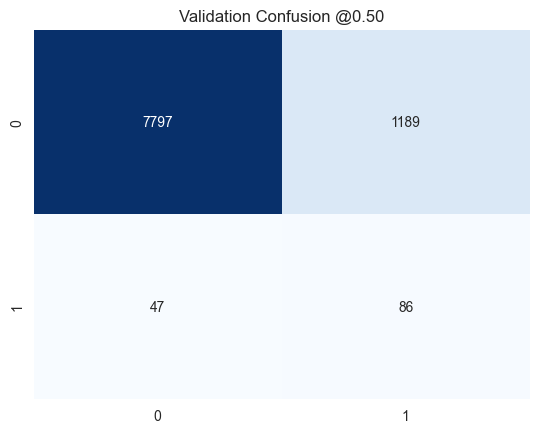

In [ ]:
y_val_pred = best_svm.predict(X_val_fs)
y_val_prob = best_svm.decision_function(X_val_fs)

print("Validation BA:", balanced_accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=3))

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion @0.50")
plt.show()

Balance accuracy is at acceptable rate, but the precision is really low, which mean there are a lot of false positive, we want to try a different weight ratio, keeping other parameters constant as best_svm

In [ ]:
pipe_custom = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("scale", StandardScaler()),
    ("svm", SVC(kernel="rbf",
                  C=0.1,
                  gamma=0.01,
                  class_weight={0:2,1:1},  #adjust weights
                  random_state=42))
    ])
pipe_custom.fit(X_tr_fs, y_tr)

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scale', StandardScaler()),
                ('svm',
                 SVC(C=0.1, class_weight={0: 2, 1: 1}, gamma=0.01,
                     random_state=42))])

Validation BA: 0.7555847107195989
              precision    recall  f1-score   support

           0      0.994     0.880     0.933      8986
           1      0.072     0.632     0.129       133

    accuracy                          0.876      9119
   macro avg      0.533     0.756     0.531      9119
weighted avg      0.980     0.876     0.922      9119



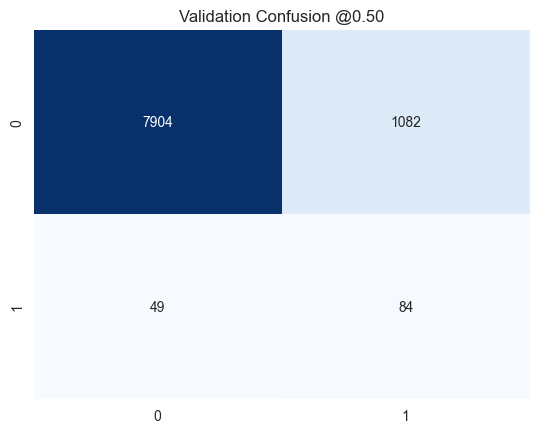

In [ ]:
y_val_pred1 = pipe_custom.predict(X_val_fs)
y_val_prob1 = pipe_custom.decision_function(X_val_fs)

print("Validation BA:", balanced_accuracy_score(y_val, y_val_pred1))
print(classification_report(y_val, y_val_pred1, digits=3))

cm = confusion_matrix(y_val, y_val_pred1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion @0.50")
plt.show()

Even though the custom weighting boosted recall, it did so at the expense of such low precision that your overall F1 and balanced‐accuracy suffered.  The second configuration gives you a more balanced trade-off: you still catch over 60% of approvals, but one in sixteen flagged policies is a true positive (instead of one in twenty‐six), yielding a much healthier F1.

## *4. Optimize threshold*

We run the model with different threshold and came to a conclusion that the best threshold is 0.24, therefore, we will finalize and compare 0.24 threshold and the default in this notebook.

In [ ]:
best_thr = 0.24
scores_c = pipe_custom.decision_function(X_val_fs)

In [ ]:
for t in [0.5, best_thr]:
    y_pred = (scores_c >= t).astype(int)
    print(f"\nThreshold = {t:.2f}")
    print(" BA:",balanced_accuracy_score(y_val,y_pred),
          "F1:",f1_score(y_val,y_pred))


Threshold = 0.50
 BA: 0.7281175897678762 F1: 0.13369467028003612

Threshold = 0.24
 BA: 0.7475337576079081 F1: 0.1308562197092084


## *5. Apply model on hold-out test set to check the performance*

X_hold_svmfs

Hold-out metrics @threshold=0.24
Balanced-Accuracy: 0.741
Precision : 0.068
Recall: 0.605
F1 Score: 0.122


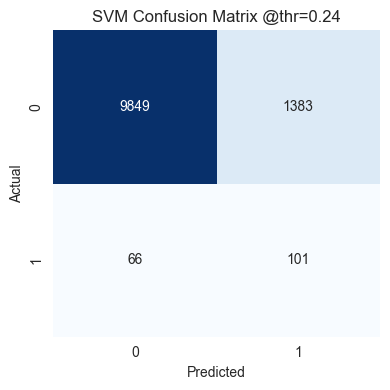

In [ ]:
scores_hold = pipe_custom.decision_function(X_hold_svmfs)

# apply tuned threshold
y_hold_pred_thr = (scores_hold >= best_thr).astype(int)

# compute metrics
ba = balanced_accuracy_score(y_hold_svm, y_hold_pred_thr)
pre = precision_score(y_hold_svm, y_hold_pred_thr, zero_division=0)
rec = recall_score(y_hold_svm, y_hold_pred_thr, zero_division=0)
f1 = f1_score(y_hold_svm, y_hold_pred_thr, zero_division=0)

print(f"Hold-out metrics @threshold={best_thr:.2f}")
print(f"Balanced-Accuracy: {ba:.3f}")
print(f"Precision : {pre:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")

# confusion matrix
cm = confusion_matrix(y_hold_svm, y_hold_pred_thr)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"SVM Confusion Matrix @thr={best_thr:.2f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Compute the hold out test prediction with default threshold of 0.5


default (0.5) threshold on hold‐out:
Balanced‐Accuracy: 0.743
Precision: 0.068
Recall: 0.611
F1 Score: 0.123


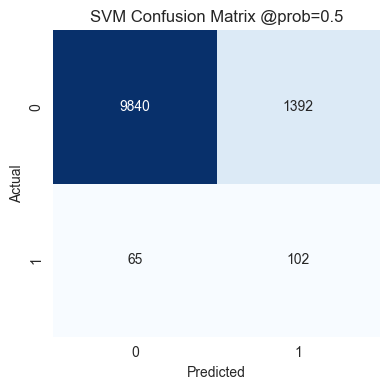

In [ ]:
y_hold_pred_def = (scores_hold >= 0.0).astype(int)
y_prob_hold = pipe_custom.decision_function(X_hold_svmfs)
y_hold_pred_050 = (y_prob_hold >= 0.5).astype(int)
y_hold_pred_050 = (scores_hold >= 0.0).astype(int)

for name, y_pred in [("default (0.5)", y_hold_pred_050)]:
    ba = balanced_accuracy_score(y_hold_svm, y_pred)
    pre = precision_score (y_hold_svm, y_pred, zero_division=0)
    rec = recall_score (y_hold_svm, y_pred, zero_division=0)
    f1 = f1_score (y_hold_svm, y_pred, zero_division=0)
    print(f"\n{name} threshold on hold‐out:")
    print(f"Balanced‐Accuracy: {ba:.3f}")
    print(f"Precision: {pre:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")


cm = confusion_matrix(y_hold_svm, y_hold_pred_050)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("SVM Confusion Matrix @prob=0.5")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## *5. Saving the model*

In [ ]:
joblib.dump(pipe_custom, "svm_rbf_model.pkl")

['svm_rbf_model.pkl']

## *6. Most importance features using Permutation Importance*


In [ ]:
r = permutation_importance(
    pipe_custom, X_hold_svmfs, y_hold_svm,
    scoring="balanced_accuracy",
    n_repeats=3,
    random_state=42,
    n_jobs=1
)

[CV] END svm__C=0.1, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=0.1, svm__kernel=rbf; total time=  44.0s
[CV] END svm__C=0.1, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=0.1, svm__kernel=sigmoid; total time= 1.1min
[CV] END svm__C=1, svm__cache_size=500, svm__class_weight=None, svm__gamma=0.01, svm__kernel=sigmoid; total time= 1.0min
[CV] END svm__C=10, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=0.01, svm__kernel=rbf; total time=  35.5s
[CV] END svm__C=0.1, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=0.1, svm__kernel=rbf; total time=  48.0s
[CV] END svm__C=10, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=0.01, svm__kernel=rbf; total time=  43.6s
[CV] END svm__C=1, svm__cache_size=500, svm__class_weight=None, svm__gamma=scale, svm__kernel=sigmoid; total time= 1.5min
[CV] END svm__C=10, svm__cache_size=500, svm__class_weight=balanced, svm__gamma=scale, svm__kernel=sigmoid; total time= 1.3min
[CV] END svm__C=

KeyboardInterrupt: 

In [ ]:
importances = pd.Series(r.importances_mean, index=selected_features)
importances = importances.sort_values(ascending=False)

print("Top 10 features importances:")
print(importances.head(10))

Top 10 features importances:
entity_a_7b5dbb09                    0.036313
revenue                              0.015408
product_id_SecurePlan OneWay         0.012570
agent_annual                         0.010378
product_id_TripGuard TicketCover     0.009089
product_id_DriveSafe Rental Addon    0.006922
age_x_score                          0.006303
reward                               0.005947
trip_length                          0.005632
annual_plan                          0.005587
dtype: float64


# V. Prediction

In [ ]:
selector = joblib.load("selector_k40svm.pkl")
svm_pipeline = joblib.load("svm_rbf_model.pkl")
keep_feats = pd.read_csv("selected_features_k40svm.csv")["feature"].tolist()

In [ ]:
X_real_test = pd.read_csv("test_encoded.csv")
X_test_fs = X_real_test[keep_feats]

In [ ]:
X_real_test.head()

,annual_plan,revenue,is_SG,agent_annual,reward,trip_length,reward_margin,agent_id,age_x_score,entity_a_0c4e727c,...,entity_type_type_a,entity_type_type_b,person_gender_08f27188,person_gender_9b2d5b46,person_gender_f67ab10a,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
0,0,-141.716239,0,1,84.316320,73,-0.594966,1,0.286979,False,...,True,False,False,True,False,False,False,False,True,False
1,0,82.225268,0,1,45.884363,25,0.558032,1,3.133421,False,...,True,False,False,True,False,False,False,False,False,True
2,0,10.247118,0,0,0.000000,6,0.000000,4,2.829156,False,...,True,False,False,True,False,False,False,True,False,False
3,0,83.483247,0,0,29.363482,73,0.351729,2,6.896156,False,...,False,True,False,False,True,False,False,False,True,False
4,0,46.679372,1,1,12.440951,32,0.266519,5,5.064746,False,...,False,True,True,False,False,False,False,True,False,False


In [ ]:
y_scores = svm_pipeline.decision_function(X_test_fs)
y_pred = svm_pipeline.predict(X_test_fs)

In [ ]:
best_thr = 0.24
y_final = (y_scores >= best_thr).astype(int)

In [ ]:
output = pd.DataFrame({
    "prediction_default": y_pred,
    "prediction_thr_%.2f" % best_thr: y_final,
    "score": y_scores
})

In [ ]:
print("Default threshold counts:")
print(output["prediction_default"].value_counts())

thr_col = f"prediction_thr_{best_thr:.2f}"
print(f"\nCounts at threshold {best_thr:.2f}:")
print(output[thr_col].value_counts())

Default threshold counts:
prediction_default
0    5507
1     826
Name: count, dtype: int64

Counts at threshold 0.24:
prediction_thr_0.24
0    5513
1     820
Name: count, dtype: int64


As expected behavior, the default threshold would give a little higher recall by trading precision. Actually, decide to choose between one of these result is tough. If in real life, the decision will be based on business purpose, whether catch all the positive claims is more important or there priority is to reduce false positives.

For this case, we chose to keep the prediction with threshold at 0.24

In [ ]:
output[["prediction_thr_0.24"]].to_csv("final_predictions_only_ChiDao_Agastya.csv", index=False)